### Nome: Samuel Felipe dos Santos

# PROJET0 2 - SOM

Relatório realizado para disciplina de Redes Neurais, contendo experimentos realizados com a rede SOM. O relatório foi desenvolvido fazendo uso da ferramenta Jupyter Notebook, e pode ser melhor visualizado em <a href="https://github.com/felipe-samuel/NeuralNetworksProjects/blob/master/project_02-som_experiments.ipynb">https://github.com/felipe-samuel/NeuralNetworksProjects/blob/master/project_02-som_experiments.ipynb</a>

## Objetivos
<UL>
<LI>Realizar experimentos com pelo menos 3 datasets (usar o
Iris para debug). Variar a vizinhança e taxa de aprendizagem

<LI>Apresentar, os seguintes mapas:
<UL>
<LI>U-Matrix
<LI>Hit map e Heat maps
<LI>Erro de quantização e topográfico

## Metodologia

Nessa seção será descrita a metodologia experimental utilizada nesse trabalho, que teve como objetivo realizar experimentos com a rede SOM. Foi realizada a variação dos parâmetros de taxa de aprendizado, tamanho da vizinhança e as constantes de decaimento desses dois parâmetros e analisado os resultados por meio das métricas de desempenho de erro de quantização e erro topográfico.
Para avaliar o que esta sendo aprendido pela rede foram gerados os gráficos Hit map, Heat maps e U-matrix para o melhor modelo encontrado.



### Bibliotecas utilizadas

Foi utilizada a linguagem de programação Python 3.0 em conjunto com as bibliotecas:
<UL>
    <LI> <b>Sklearn:</b> Possui rotinas de aprendizados de máquina;
    <LI> <b>Pandas:</b> Utilizada para criação de tabelas;
    <LI> <b>Seaborn e Mathplotlib:</b> Possuem rotinas de criação de gráfico. 
</UL>

In [2]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import HTML
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler

## Implementação da Rede SOM

Foi desenvonvida uma implementação da rede SOM (Self-organizing Maps) na forma da classe SOM com os seguintes parâmetros:

<UL>
<LI> <b>input_size:</b> Dimensionalidade esperada de uma amostra de entrada da rede. valor padrão=[10];
<LI> <b>grid_size:</b> Dimensões (altura e largura) da rede de neurônios. Padrão=[10,10];
<LI> <b>max_iterations:</b> Número máximo de épocas a serem executadas. Padrão=100;
<LI> <b>lr:</b> Taxa de aprendizado inicial. Padrão=0.6;
<LI> <b>sigma:</b> Constante relacionada ao tamanho da vizinhança. Padrão=1;
<LI> <b>tau:</b> Constante relacionada ao decaimento do tamanho da vizinhança. Padrão=10;
<LI> <b>tau_2:</b> Constante relacionada ao decaimento da taxa de aprendizado. Padrão=10;
<LI> <b>shuffle:</b> Indica se os dados de entrada devem ser embaralhadas antes de cada época. Padrão=True;    
</UL>

In [3]:
class SOM:
    def __init__(self, input_size=[10], grid_size=[10,10], max_iterations=100, lr=0.6, sigma=1,
                 tau=10, tau_2=10, shuffle=True):
        self.input_size = input_size
        self.grid_size = grid_size
        self.max_iterations = max_iterations
        self.lr = lr
        self.sigma = sigma
        self.tau = tau
        self.tau_2 = tau_2
        self.shuffle = shuffle
        
        self.iteration = 0
        self.weights = np.random.random_sample(grid_size + list(input_size))
        self.discriminant = np.zeros(grid_size)
        self.h = np.zeros(grid_size + [1])

Os seguintes métodos foram implementados pra serem utilizados apenas internamente pela classe e dar suporte a implementação dos demais métodos:

<UL>
<LI> <b>discriminant_function:</b> Calcula uma matriz que indica a diferença entre uma amostra da entrada (input_sample) e os pesos de cada neurônio;
<LI> <b>distance:</b> Retorna a distância Euclidiana entre p e q. É utilizada para calcular a distância topológica entre dois neurônios;
<LI> <b>current_sigma:</b> Retorna o valor de Sigma para a época atual levando em conta o decaimento;
<LI> <b>neighborhood_function:</b> Função que define a vizinhança do neurônio o menor valor descriminante (BMU) de acordo com a constante Sigma;
<LI> <b>are_neighbors:</b> Retorna se os neurônios p e q são vizinhos no grid, ou seja, se a distância euclidiana entre eles é menor que um valor max_distance (Definido como 1.5 por padrão);
<LI> <b>current_lr:</b> Retorna a taxa de aprendizado da época atual aplicando o decaimento.
</UL>

In [4]:
def discriminant_function(self, input_sample):
    for i in range(self.grid_size[0]):
        for j in range(self.grid_size[1]):
            self.discriminant[i,j] = np.sum(np.power(self.weights[i,j] - input_sample, 2))
SOM.discriminant_function = discriminant_function

def distance(self, p, q):
    return sqrt(np.sum((p-q)**2))
SOM.distance = distance

def current_sigma(self):
    return self.sigma * exp(-self.iteration/self.tau)
SOM.current_sigma = current_sigma

def neighborhood_function(self, n1_pos, n2_pos):
    return exp( - (self.distance(n2_pos, n1_pos)**2)/(2*(self.current_sigma()**2) ))
SOM.neighborhood_function = neighborhood_function

def are_neighbors(self, p, q, max_distance=1.5):
    if self.distance(p,q) <= max_distance:
        return True
    else:
        return False
SOM.are_neighbors = are_neighbors

def current_lr(self):
    return self.lr * exp(-self.iteration/self.tau_2)
SOM.current_lr=current_lr

O treinamento da rede em uma amostra por uma época é realizada pelo método <b>partial_fit_sample</b>, que chama as fases do aprendizado da rede:

<UL>
<LI> <b>competitive_phase:</b> Fase de competição entre os neurônios, onde é calculada a função discriminante para cada um, por meio da qual é escolhido o neurônio mais similar da amostra de entrada (BMU);

<LI> <b>cooperative_phase:</b> Fase de cooperação entre os neurônios, onde é definida uma vizinança topológica para o neurônio BMU, que também tera seus pesos atualizados;

<LI> <b>adaptation:</b> Fase onde ocorre o aprendizado. Os pesos do neurônio BMU e seus vizinhos são atualizados para se tornarem mais simimilares a amostra de entrada;
</UL>


In [5]:
def competitive_phase(self, input_sample):
    self.discriminant_function( input_sample )
    BMU = np.unravel_index(self.discriminant.argmin(), self.discriminant.shape)
    return np.array(BMU)
SOM.competitive_phase = competitive_phase

def cooperative_phase(self, BMU):
    for i in range(self.grid_size[0]):
        for j in range(self.grid_size[1]):
            self.h[i,j] = self.neighborhood_function(BMU, [i,j])
SOM.cooperative_phase=cooperative_phase
            
def adaptation(self, input_sample):        
    self.weights += self.current_lr() * self.h * (input_sample - self.weights)
SOM.adaptation = adaptation
    
def partial_fit_sample(self, sample):
    BMU = self.competitive_phase(sample)
    self.cooperative_phase(BMU)
    self.adaptation(sample)
SOM.partial_fit_sample = partial_fit_sample

Os métodos a seguir foram desenvolvidos para serem utilizadas pelo usuário para realizar o treinamento da rede SOM.

<UL>
<LI> <b>partial_fit:</b> Executa o treinamento da rede sobre os dados (data) por uma época.
Pode ser definido um tamanho de batch (batch_size) que por padrão é 1.
Caso esse valor seja definido, os dados de entrada serão divididos em grupos com o tamanho do batch,
sendo calculado uma amostra média para cada grupo, que é utilizada para treinar a rede;

<LI> <b>fit:</b> Realiza multiplas épocas de treinamento (max_iterations) sobre os dados (data) utilizando um tamanho de batch (batch_size). 
</UL>

In [6]:
def partial_fit(self, data, batch_size=1):
    for i in range(int(len(data)/batch_size)):
        if self.shuffle==True:
            index = np.random.permutation(len(data))
        else:
            index = np.array(range(len(data)))            
        batch = data[ index[batch_size*i : batch_size*(i+1)] ]
        if batch_size > 1:
            sample = batch.mean(batch, axis=1)
        else:
            sample = batch
        self.partial_fit_sample(sample)
SOM.partial_fit = partial_fit

def fit(self, data, batch_size=1, max_iterations=None):
    if not(max_iterations is None):
        self.max_iterations = max_iterations
    self.iteration = 0
    self.weights = np.random.random_sample(self.grid_size + list(self.input_size))
    while self.iteration < self.max_iterations:
        self.partial_fit(data, batch_size)
        self.iteration+=1
SOM.fit = fit

Para realizar a avaliação do desempenho da rede foram implementados os seguintes métodos que calculam métricas de erro:

<UL>
    <LI><b>quantization_error:</b> Erro de quantização, que indica o quão diferente cada amostra dos dados de entrada (data) é dos pesos do neurônio BMU;
    <LI><b>quantization_error:</b> Erro topográfico, que indica, para cada amostra da entrada, se os dois neurônios BMU são vizinhos;

In [7]:
def quantization_error(self, data):
    error = 0.0
    for i in range(len(data)):
        input_sample = data[i]
        BMU_i, BMU_j = self.competitive_phase(input_sample)
        error+= self.distance(self.weights[BMU_i, BMU_j],input_sample)
    error /= len(data)
    return error
SOM.quantization_error = quantization_error

def topographical_error(self, data):
    error = 0.0
    for i in range(len(data)):
        input_sample = data[i]
        BMU = self.competitive_phase(input_sample)
        self.discriminant[BMU[0], BMU[1]] = self.grid_size[0] + self.grid_size[1]
        BMU2 = np.unravel_index(self.discriminant.argmin(), self.discriminant.shape)
        if not self.are_neighbors(BMU, BMU2):
            error += 1.0
    error /= len(data)
    return error
SOM.topographical_error = topographical_error

Foram implementados também métodos para gerar as matrizes que podem ser usadas para gerar os seguintes gráficos:
<UL>
<LI> <b> U-matrix</b>
<LI> <b> HeatMap</b>
<LI> <b> HitMap</b>
</UL>

In [8]:
def u_matrix(self):
    um = np.zeros(self.grid_size)
    for i in range(self.grid_size[0]):
        for j in range(self.grid_size[1]):
            neighbors = [ [i+1,j-1], [i+1, j], [i+1,j+1],
                          [i  ,j-1], [i  , j], [i  ,j+1],
                          [i-1,j-1], [i-1, j], [i-1,j+1] ]
            d = 0
            for x,y in neighbors:
                if x > 0 and x < self.grid_size[0] and y > 0 and y < self.grid_size[1]:
                    um[i,j] += self.distance(self.weights[i,j], self.weights[x,y])
    return um
SOM.u_matrix = u_matrix

In [9]:
def heatmap(self, sample): 
    hem = np.zeros(self.grid_size)
    for i in range(self.grid_size[0]):
        for j in range(self.grid_size[1]):
            hem[i,j] = self.distance(self.weights[i,j], sample)
    return hem
SOM.heatmap = heatmap

In [10]:
def hitmap(self, data):
    n=0
    hm = np.zeros(self.grid_size)
    for i in range(len(data)):
        BMU = self.competitive_phase(data[i])
        hm[BMU[0], BMU[1]] += 1
        n+=1
    return hm
SOM.hitmap = hitmap

Abaixo é mostrado um exemplo simples de utilização da rede.

In [11]:
s=SOM(input_size=[4], grid_size=[1,2], max_iterations=200, lr=0.6, sigma=0.001, tau=1, tau_2=10)
data = np.array([[1,1,0,0],[0,0,0,1],[1,0,0,0],[0,0,1,1]])
s.fit(data = data )

In [12]:
print('Pesos dos neuronios:\n',s.weights)
print('Erro de quantização:',s.quantization_error(data))
print('Erro Topografico:',s.topographical_error(data))

Pesos dos neuronios:
 [[[9.99999955e-01 4.90223327e-01 5.56626483e-08 4.80505378e-09]
  [6.53813328e-08 1.60345019e-07 4.85782365e-01 9.99999823e-01]]]
Erro de quantização: 0.5000000000000333
Erro Topografico: 0.0


### Datasets
Foram escolhidos os seguintes três datasets para avaliação dos resultados:
<UL>
<LI><b>Iris Dataset:</b> consiste de 50 amostras  de cada uma das 3 espécies da flor iris, que esta disponivel no pacote Sklearn;

<LI><b>Breast Cancer Wisconsin (Diagnostic) Dataset:</b> características computadas a partir de imagens biomédicas, e utilizadas para classificar se há câncer de mama, mais detalhes podem ser encontrados em 
<a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)</a>. Foi utilizada a versão disponibilizada no pacote Sklearn;

<LI><b>Alcohol QCM Sensor Dataset Dataset:</b> consiste de amostras de álcool que podem ser classificadas em 5 tipos (1-octanol, 1-propanol, 2-butanol, 2-propanol, 1-isobutanol). Os atributos de cada amostra consistem de medições realizadas por sensores com diferentes configurações, que atribuidas sobre a amostra no formato de gás em diferentes concentrações. Foi utilizado a versão do dataset disponível em <a href="https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset">https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset</a>, onde se encontram mais detalhes.
</UL>


### Pré-processamento dos dados

Os dados então são normalizados utilizando a função <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> da biblioteca Sklearn, que realiza a seguinte operação:<br />
<br />
z = (x - u) / s<br />
<br />
Onde x é uma amostra, u é a média das amostras do treino e s o desvio padrão do treino.


In [13]:
def Normalize( X ):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

### Otimização dos Hiperparâmetros da Rede

Inicialmente foi fixada uma rede com um grid de dimensões (10,10) para a realização dos experimentos. Foram então variados os hiperparâmetros lr, sigma, tau e tau_2, como pode ser visto abaixo.

In [14]:
parameters = {
    'grid_size' :[[10,10]],    
    'lr' :       [0.005, 0.05, 0.5],
    'sigma' :    [1 , 5 , 10],
    'tau' :      [10, 20, 40],
    'tau_2' :    [10, 20, 40]
}

A busca pelos hiperparâmetros ideais foi realizada pela função <b>grid_serach</b> implementada a seguir. Ela realiza uma busca exaustiva sobre um dicionário de hiperparâmetros. Cada combinação de hiperparâmetros é utilizada para treinar a rede 3 vezes, obtendo um erro de quantização médio, erro de topográfico médio e o desvio padrão de ambos para cada combinação de hiperparâmetros.

In [15]:
def grid_search(parameters, data, repetitions=3):
    results = {
        'grid_size' :[],    
        'lr' : [],
        'sigma' : [],
        'tau' : [],
        'tau_2' : [],
        'quantization_error': [],
        'topographical_error': [],
        'quantization_error_std': [],
        'topographical_error_std': []
    }
    total = len(parameters['grid_size']) * len(parameters['lr']) * len(parameters['sigma']) * len(parameters['tau']) * len(parameters['tau_2']) * repetitions
    i=1
    for gs in parameters['grid_size']:
        for lr in parameters['lr']:
            for sigma in parameters['sigma']:
                for tau in parameters['tau']:
                    for tau_2 in parameters['tau_2']:
                        qe = []
                        te = []
                        for r in range(repetitions):
                            print(i, 'of', total, gs, lr, sigma, tau, tau_2, r )
                            s=SOM(input_size=[ len(data[0]) ], grid_size=gs, max_iterations=100, lr=lr, sigma=sigma, tau=tau, tau_2=tau_2)
                            s.fit(data)
                            q = s.quantization_error(data)
                            t = s.topographical_error(data)                            
                            print(q, t)
                            qe += [q]
                            te += [t]
                            i+=1
                        qe_mean = np.mean(qe)
                        qe_std = np.std(qe)
                        te_mean = np.mean(te)
                        te_std = np.std(te)
                        results['grid_size'] += [gs]    
                        results['lr'] += [lr]
                        results['sigma'] += [sigma]
                        results['tau'] += [tau]
                        results['tau_2'] += [tau_2]
                        results['quantization_error'] += [qe_mean]
                        results['topographical_error'] += [te_mean]
                        results['quantization_error_std'] += [qe_std]
                        results['topographical_error_std'] += [te_std]      
    return results

Os modelos são ordenados de acordo com o erro quantitativo, sendo selecionado os 10 mehores. Dentre esses modelos, o que tiver o menor erro topográfico é escolhido como o melhor modelo e utilizado nos experimentos seguintes.

### Avaliação do Modelo

O melhor modelo escolhido é avaliado então em três datasets, levando em consideração o erro quantitativo e topográfico e os gráficos Heat Map, Hit Map e U-matrix.

O <b>Heat Map</b> gerado tem como entrada um exemplo do dataset e mede a distância euclidiana dos pesos desse exemplo os pesos de cada neurônio do mapa. Esse gráfico foi gerado para três exemplos de cada classe, sendo possível analisar como os pesos desses exemplos se comparam com os do mapa.  

O <b>Hit Map</b> gerado mostra a quantidade de vezes que cada neurônio do mapa foi considerado o BMU para um exemplo do dataset. Foram gerado um Hit Mapa para cada classe do dataset, sendo possível verificar onde no mapa cada classe se encontra.

Por fim, a <b>U-matrix</b> mede a distância dos pesos de cada neurônio com os pesos dos seus vizinhos doretos, sendo possível verificar quais áreas do mapa possuem neurônios mais próximos uns aos outros e em quais eles estão distantes. 


## Resultados

### Dataset 1: Iris

In [16]:
def loadIris():
    iris = load_iris()
    return iris.data, iris.target
iris_X, iris_Y = loadIris()

In [17]:
iris_X = Normalize(iris_X)

In [ ]:
results = grid_search(parameters, iris_X)

Como pode ser visto na tabela a seguir, que mostra os dez melhores modelos de acordo com o erro de quantização, a maior taxa de aprendizado testado se mostrou melhor (lr=0.5). Todos os valores de sigma (que define o tamaho da vizinhança) apareceram entre os melhores resultados, no entanto, sigma=1 apareceu mais vezes que os demais. Para os valores de tau o valor mais alto (40) apareceu com menor frequência que os demais, mostrando que a rede da preferência a um decaimento mais rápido do tamanho da vizinhança. Já para o tau_2 o menor valor (10), não foi encontrado entre os melhores resultados, mostrando que o decaimento mais lento da taxa de aprendizado é benéfico. 

In [116]:
Iris_results =pd.DataFrame.from_dict(results)
export_csv = Iris_results.to_csv(r'results/SOM/Iris_grid_search.csv', index = None, header=True)

In [3]:
Iris_results_table = pd.read_csv('results/SOM/Iris_grid_search_sample.csv')
Iris_results_table

,grid_size,lr,sigma,tau,tau_2,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,"[10, 10]",0.5,1,40,40,0.114791,0.191111,0.003265,0.038618
1,"[10, 10]",0.5,5,10,40,0.116410,0.188889,0.005459,0.021999
2,"[10, 10]",0.5,1,20,40,0.118245,0.213333,0.005969,0.032660
3,"[10, 10]",0.5,1,10,40,0.122050,0.193333,0.006257,0.016330
4,"[10, 10]",0.5,1,10,20,0.122373,0.195556,0.001625,0.026851
5,"[10, 10]",0.5,10,10,40,0.128736,0.160000,0.003006,0.038103
6,"[10, 10]",0.5,5,20,40,0.129532,0.113333,0.002980,0.016330
7,"[10, 10]",0.5,1,20,20,0.132990,0.188889,0.001927,0.021999
8,"[10, 10]",0.5,5,10,20,0.135172,0.091111,0.005383,0.040855
9,"[10, 10]",0.5,10,20,40,0.139476,0.111111,0.002978,0.017498


O seguinte modelo foi definido como o mehor por estar entre os dez melhores em relação ao erro de quantização, e dentre esses modelos, possuir o menor erro topográfico.

In [5]:
print(Iris_results_table.loc[[8]])

  grid_size   lr  sigma  tau  tau_2  quantization_error  topographical_error  \
8  [10, 10]  0.5      5   10     20            0.135172             0.091111   

   quantization_error_std  topographical_error_std  
8                0.005383                 0.040855  


In [195]:
s=SOM(input_size=[len(iris_X[0])], grid_size=[10,10], max_iterations=100, lr=0.5, sigma=5, tau=10, tau_2=20)
s.fit(data = iris_X )

A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo, podendo ser observado que foi obtido um resultado baixo em ambos.

In [196]:
print('Erro de quantização =', s.quantization_error(iris_X))
print('Erro Topografico =', s.topographical_error(iris_X))

Erro de quantização = 0.12418833555203086
Erro Topografico = 0.16666666666666666


A seguir é apresentado o Heat Map para três exemplos de cada classe. Pode ser observado que na maioria dos exemplos, a distância é pequena para um grupo de alguns neurônios próximos uns aos outros, e grande para os demais. No entanto, o segundo exemplo da classe versicolour aparenta ter dois grupos onde a distância é pequena.

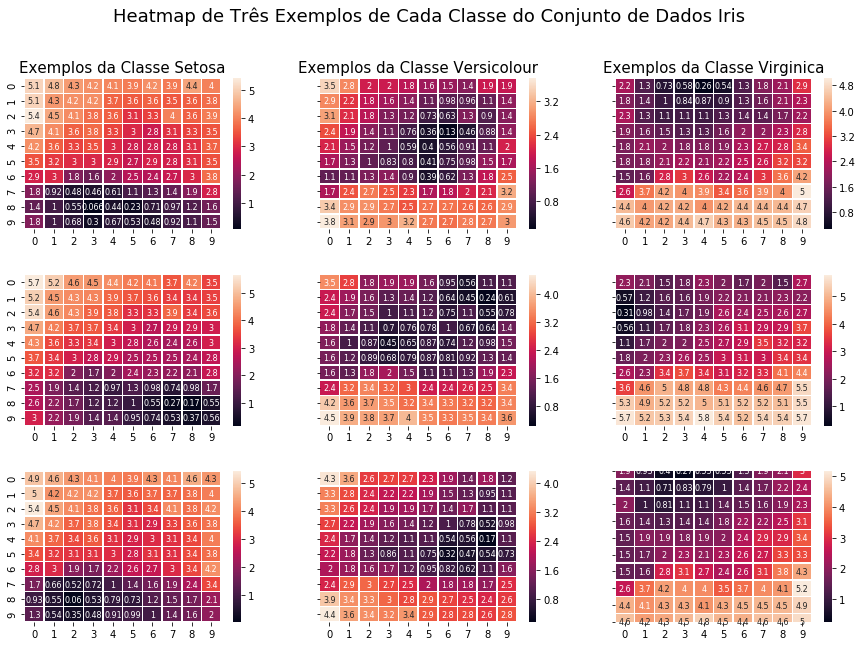

In [197]:
plt.rcParams['figure.figsize'] = [15, 10]
f, ax = plt.subplots(3, 3, sharey=True)
f.suptitle('Heatmap de Três Exemplos de Cada Classe do Conjunto de Dados Iris', fontsize=18)

p1 = sns.heatmap(s.heatmap(iris_X[0 ]), linewidth=0.5, annot=True, ax = ax[0,0], annot_kws={"size": 8})
p2 = sns.heatmap(s.heatmap(iris_X[12]), linewidth=0.5, annot=True, ax = ax[1,0], annot_kws={"size": 8})
p3 = sns.heatmap(s.heatmap(iris_X[48]), linewidth=0.5, annot=True, ax = ax[2,0], annot_kws={"size": 8})

p4 = sns.heatmap(s.heatmap(iris_X[66]), linewidth=0.5, annot=True, ax = ax[0,1], annot_kws={"size": 8})
p5 = sns.heatmap(s.heatmap(iris_X[83]), linewidth=0.5, annot=True, ax = ax[1,1], annot_kws={"size": 8})
p6 = sns.heatmap(s.heatmap(iris_X[90]), linewidth=0.5, annot=True, ax = ax[2,1], annot_kws={"size": 8})

p8  = sns.heatmap(s.heatmap(iris_X[100]), linewidth=0.5, annot=True, ax = ax[0,2], annot_kws={"size": 8})
p9  = sns.heatmap(s.heatmap(iris_X[122]), linewidth=0.5, annot=True, ax = ax[1,2], annot_kws={"size": 8})
p10 = sns.heatmap(s.heatmap(iris_X[144]), linewidth=0.5, annot=True, ax = ax[2,2], annot_kws={"size": 8})

p1.set_title('Exemplos da Classe Setosa',      fontsize=15)
p4.set_title('Exemplos da Classe Versicolour', fontsize=15)
p8.set_title('Exemplos da Classe Virginica',   fontsize=15)

f.subplots_adjust(hspace=0.3)

O Hit Map mostra que as classes Setosa esta completamente separada das demais, não compartilhando neurônios BMU em nenhum de seus exemplos com outras classes. As classes Virginica e Versicolor ocupam lugares diferentes do mapa para maioria de seus exemplos, no entanto, uma pequena quantidade de exemplos da classe Versicolour esta na que é predominantemente ocupada por exemplos da classe Virginica.

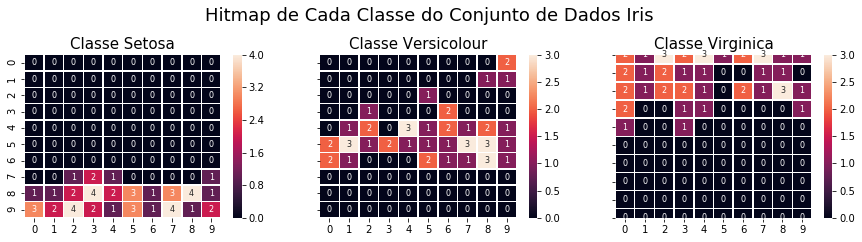

In [198]:
plt.rcParams['figure.figsize'] = [15, 3]
f, ax = plt.subplots(1, 3, sharey=True)

f.suptitle('Hitmap de Cada Classe do Conjunto de Dados Iris', fontsize=18, x=0.5, y=1.1)

p1 = sns.heatmap(s.hitmap(iris_X[iris_Y==0]), linewidth=0.5, annot=True, ax = ax[0], annot_kws={"size": 8})
p2 = sns.heatmap(s.hitmap(iris_X[iris_Y==1]), linewidth=0.5, annot=True, ax = ax[1], annot_kws={"size": 8})
p3 = sns.heatmap(s.hitmap(iris_X[iris_Y==2]), linewidth=0.5, annot=True, ax = ax[2], annot_kws={"size": 8})

p1.set_title('Classe Setosa',      fontsize=15)
p2.set_title('Classe Versicolour', fontsize=15)
p3.set_title('Classe Virginica',   fontsize=15)

f.subplots_adjust(hspace=0.3)

Por fim foi gerado a U-Matrix do mapa, que há uma distância maior entre os pesos dos neurônios próximos as fronteiras das classes Setosa e Versicolour e distâncias menores no restante do mapa. Junto com os demais gráficos, isso aponta que os exemplos da classe Setosa estão mais separados dos demais, sendo mapeados em neurônios com pesos mais distantes das demais classes, enquanto a uma certa proximidade entre os pesos dos neurônios onde foram mapeados as demais classes.

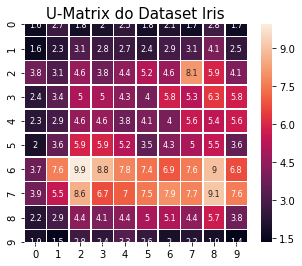

In [199]:
plt.rcParams['figure.figsize'] = [5, 4]
ax = sns.heatmap(s.u_matrix( ), linewidth=0.5, annot=True, annot_kws={"size": 8})
ax.set_title('U-Matrix do Dataset Iris', fontsize=15)
plt.show()

### Dataset 2:  breast cancer wisconsin dataset

In [16]:
def loadBCWD():
    BCWD = load_breast_cancer()
    return BCWD.data, BCWD.target
BCWD_X, BCWD_Y = loadBCWD()

In [17]:
BCWD_X = Normalize(BCWD_X)

In [ ]:
results = grid_search(parameters, BCWD_X)

In [152]:
BCWD_results =pd.DataFrame.from_dict(results)
export_csv = BCWD_results.to_csv(r'results/SOM/BCWD_grid_search.csv', index = None, header=True)

A tabela a seguir mostra os dez melhores modelos de acordo com o erro de quantização para o breast cancer wisconsin dataset. Foram obtidos resultados muito similares ao Iris dataset, pois a maior taxa de aprendizado testado se mostrou melhor (lr=0.5), todos os valores de sigma apareceram entre os melhores resultados mas sigma=1 apareceu mais vezes que os demais, o valor mais alto de tau (40) e o mais baixo de tau_2 (10) apareceram com menor frequência.

No entanto foram obtidos modelos com erro de quantização e erro topográfico mais alto, o que mostra que esse dataset é mais desafiador para esse método que o Iris.

In [4]:
BCWD_results_table = pd.read_csv('results/SOM/BCWD_grid_search_sample.csv')
BCWD_results_table

,grid_size,lr,sigma,tau,tau_2,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,"[10, 10]",0.5,1,10,40,1.903770,0.687170,0.001606,0.003515
1,"[10, 10]",0.5,1,20,40,1.920579,0.666960,0.001009,0.011424
2,"[10, 10]",0.5,1,10,20,1.927627,0.586995,0.004809,0.017575
3,"[10, 10]",0.5,5,10,40,1.931224,0.566784,0.000050,0.021968
4,"[10, 10]",0.5,10,10,40,1.931487,0.514938,0.006904,0.066784
5,"[10, 10]",0.5,1,40,40,1.944602,0.484183,0.004299,0.021968
6,"[10, 10]",0.5,1,20,20,1.950515,0.450791,0.008678,0.050088
7,"[10, 10]",0.5,1,10,10,1.970941,0.391916,0.002620,0.007030
8,"[10, 10]",0.5,5,10,20,1.973954,0.387522,0.001103,0.034271
9,"[10, 10]",0.5,5,20,40,1.982452,0.409490,0.001495,0.019332


O modelo com os seguintes hiperparâmetros foi definido como o mehor por estar entre os dez melhores em relação ao erro de quantização, e dentre esses modelos, possuir o menor erro topográfico.

In [5]:
BCWD_results_table.loc[[8]]

,grid_size,lr,sigma,tau,tau_2,quantization_error,topographical_error,quantization_error_std,topographical_error_std
8,"[10, 10]",0.5,5,10,20,1.973954,0.387522,0.001103,0.034271


In [20]:
s=SOM(input_size=[len(BCWD_X[0])], grid_size=[10,10], max_iterations=100, lr=0.5, sigma=5, tau=10, tau_2=20)
s.fit(data = BCWD_X )

A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo, podendo ser observado que foram encontrados resultados mais altos que no dataset Iris.

In [21]:
print('Erro de quantização =', s.quantization_error(BCWD_X))
print('Erro Topografico =', s.topographical_error(BCWD_X))

Erro de quantização = 1.983173350123974
Erro Topografico = 0.36731107205623903


O Heat Map  é apresentado a seguir para três exemplos de cada classe. Pode ser observado para os dois primeiros exemplos da classe negativa, há poucos neurônios cujo os pesos apresentam uma distância pequena em relação aos pesos do exemplo e estes neurônios estão proximos um dos outros. No entanto, para o terceiro exemplo da Classe negativa e para todos da classe positiva, os neurônios com pequena distância aparentam estar mais espalhados, estando um pouco mais distantes um dos outros no grid da rede.

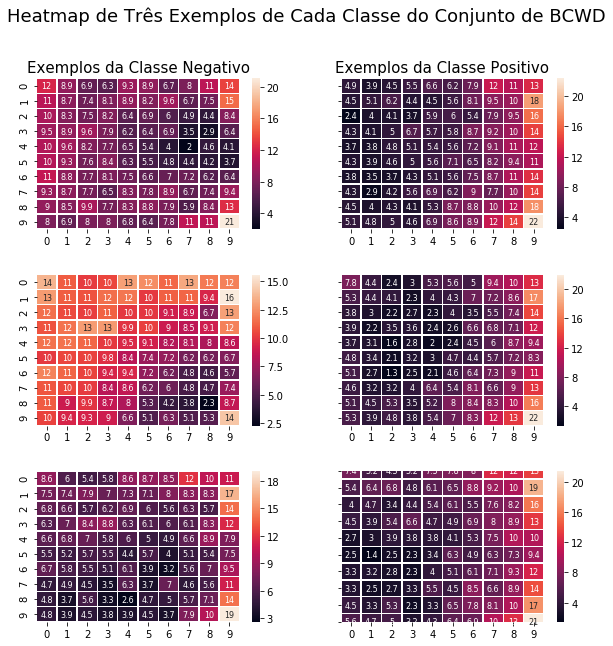

In [22]:
plt.rcParams['figure.figsize'] = [10, 10]
f, ax = plt.subplots(3, 2, sharey=True)
f.suptitle('Heatmap de Três Exemplos de Cada Classe do Conjunto de BCWD', fontsize=18)

p1 = sns.heatmap(s.heatmap(BCWD_X[  8]), linewidth=0.5, annot=True, ax = ax[0,0], annot_kws={"size": 8})
p2 = sns.heatmap(s.heatmap(BCWD_X[250]), linewidth=0.5, annot=True, ax = ax[1,0], annot_kws={"size": 8})
p3 = sns.heatmap(s.heatmap(BCWD_X[566]), linewidth=0.5, annot=True, ax = ax[2,0], annot_kws={"size": 8})

p4 = sns.heatmap(s.heatmap(BCWD_X[ 37]), linewidth=0.5, annot=True, ax = ax[0,1], annot_kws={"size": 8})
p5 = sns.heatmap(s.heatmap(BCWD_X[249]), linewidth=0.5, annot=True, ax = ax[1,1], annot_kws={"size": 8})
p6 = sns.heatmap(s.heatmap(BCWD_X[486]), linewidth=0.5, annot=True, ax = ax[2,1], annot_kws={"size": 8})

p1.set_title('Exemplos da Classe Negativo', fontsize=15)
p4.set_title('Exemplos da Classe Positivo', fontsize=15)
f.subplots_adjust(hspace=0.3)

No Hit Map é possível perceber que exemplos da classe negativa se concentraram na região inferior direita do mapa, enquanto os exemplos da classe positiva se concentraram na região superior direita. No entanto, é possível perceber que próximos a região de fronteira entre as classes, há exemplos de ambas as classes mapeadas para o mesmo neurônio.

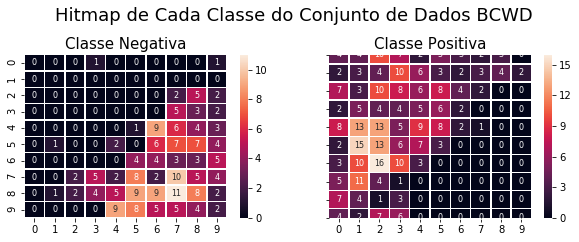

In [23]:
plt.rcParams['figure.figsize'] = [10, 3]
f, ax = plt.subplots(1, 2, sharey=True)

f.suptitle('Hitmap de Cada Classe do Conjunto de Dados BCWD', fontsize=18, x=0.5, y=1.1)

p1 = sns.heatmap(s.hitmap(BCWD_X[BCWD_Y==0]), linewidth=0.5, annot=True, ax = ax[0], annot_kws={"size": 8})
p2 = sns.heatmap(s.hitmap(BCWD_X[BCWD_Y==1]), linewidth=0.5, annot=True, ax = ax[1], annot_kws={"size": 8})

p1.set_title('Classe Negativa', fontsize=15)
p2.set_title('Classe Positiva', fontsize=15)

f.subplots_adjust(hspace=0.3)

Na U-Matrix obtida, é possível perceber que a região onde os exemplos da classe positiva foram mapeados os neurônios são próximos um aos outros e na região onde os exemplos da classe negativa foram mapeados os neurônios estão mais distantes um dos outros.

De forma geral, pode ser observado que para esse dataset há uma separação topológica das classes, no entanto, exemplos mapeados na fronteira das regiões topológicas das classes podem ser confundidos e a classe positiva, que apresentou neurónios mais próximos entre si, possui exemplos cujo os neurônios com menor distâncio dos seus pesos estão um pouco distantes no grid. Esses fatores podem ter levado ao erro quantitativo e topológico um pouco mais alto obtido nesse dataset. 

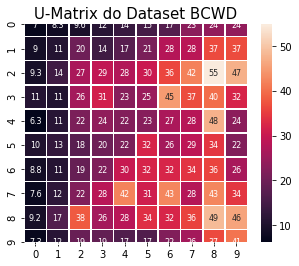

In [24]:
plt.rcParams['figure.figsize'] = [5, 4]
ax = sns.heatmap(s.u_matrix( ), linewidth=0.5, annot=True, annot_kws={"size": 8})
ax.set_title('U-Matrix do Dataset BCWD', fontsize=15)
plt.show()

### Dataset 3:  Alcohol QCM Sensor Dataset Data Set

In [30]:
def loadQCM():
    QCM3  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM3.csv', sep=';', header=0)
    QCM3['MIP'] = 1.0
    QCM3['NP']  = 1.0
    QCM6  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM6.csv', sep=';', header=0)
    QCM6['MIP'] = 1.0
    QCM6['NP']  = 0.0
    QCM7  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM7.csv', sep=';', header=0)
    QCM7['MIP'] = 1.0
    QCM7['NP']  = 0.5
    QCM10 = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM10.csv', sep=';', header=0)
    QCM10['MIP'] = 1.0
    QCM10['NP']  = 2.0
    QCM12 = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM12.csv', sep=';', header=0)
    QCM12['MIP'] = 0.0
    QCM12['NP']  = 1.0
    QCM = pd.concat([QCM3,QCM6,QCM7,QCM10,QCM12], ignore_index=True)
    QCM_X = np.concatenate( [np.array(QCM)[:,0:10], np.array(QCM)[:,15:17]], axis=1)
    QCM_Y_OneHot = np.array(QCM)[:,10:15]
    
    QCM_Y = np.zeros(len(QCM_Y_OneHot))
    for i in range(len(QCM_Y_OneHot)):
        for j in range(len(QCM_Y_OneHot[i])):
            if QCM_Y_OneHot[i,j] == 1:
                QCM_Y[i] = j
                break
    
    return QCM_X, QCM_Y
    
QCM_X, QCM_Y = loadQCM()

In [31]:
QCM_X = Normalize(QCM_X)

In [ ]:
results = grid_search(parameters, QCM_X)

In [118]:
QCM_results =pd.DataFrame.from_dict(results)
export_csv = QCM_results.to_csv(r'results/SOM/QCM_grid_search.csv', index = None, header=True)

A tabela abaixo apresenta os 10 melhores resultados de acordo com o erro quantitativo para o  Alcohol QCM Sensor Dataset Data Set. Foram obtidos resultados muito similares aos dataset anteriores, com a maior taxa de aprendizado sendo lr=0.5, o valor mais alto de tau (40) e o mais baixo de tau_2 (10) aparecendo com menor frequência. Quanto ao sigma, todos os valores testados apareceram estre os melhores resultados, com frequência próxima. Pode ser observado que foi obtido um erro quatitativo e topográfico baixo.


In [6]:
QCM_results_table = pd.read_csv('results/SOM/QCM_grid_search_sample.csv')
QCM_results_table

,lr,sigma,tau,tau_2,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,0.5,5,20,40,0.109349,0.008000,0.006724,0.011314
1,0.5,1,40,40,0.110090,0.021333,0.003961,0.019956
2,0.5,5,10,40,0.112929,0.002667,0.004255,0.003771
3,0.5,1,20,40,0.117524,0.024000,0.003263,0.017282
4,0.5,10,10,40,0.119367,0.013333,0.007352,0.018856
5,0.5,1,20,20,0.120068,0.029333,0.001733,0.024730
6,0.5,5,10,20,0.122154,0.013333,0.005475,0.009978
7,0.5,1,10,40,0.124433,0.024000,0.007194,0.017282
8,0.5,10,20,40,0.125864,0.008000,0.005611,0.006532
9,0.5,10,10,20,0.130656,0.005333,0.004008,0.003771


O seguinte modelo foi definido como o mehor por estar entre os dez melhores em relação ao erro de quantização, e dentre esses modelos, possuir o menor erro topográfico.

In [7]:
QCM_results_table.loc[[2]]

,lr,sigma,tau,tau_2,quantization_error,topographical_error,quantization_error_std,topographical_error_std
2,0.5,5,10,40,0.112929,0.002667,0.004255,0.003771


In [32]:
s=SOM(input_size=[len(QCM_X[0])], grid_size=[10,10], max_iterations=100, lr=0.5, sigma=5, tau=10, tau_2=40)
s.fit(data = QCM_X )

A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo, podendo ser observado que ambos foram baixos.

In [33]:
print('Erro de quantização =', s.quantization_error(QCM_X))
print('Erro Topografico =', s.topographical_error(QCM_X))

Erro de quantização = 0.11892151494203088
Erro Topografico = 0.016


Os Heat Maps gerado mostra que a distância entre os pesos de um exemplo é pequena para um pequeno grupo de neurônios próximos topograficamente no grid e distante para os demais, no entanto, pode ser notado que os exemplos de classes diferentes estão sendo mapeados para regiões próximas no mapa.

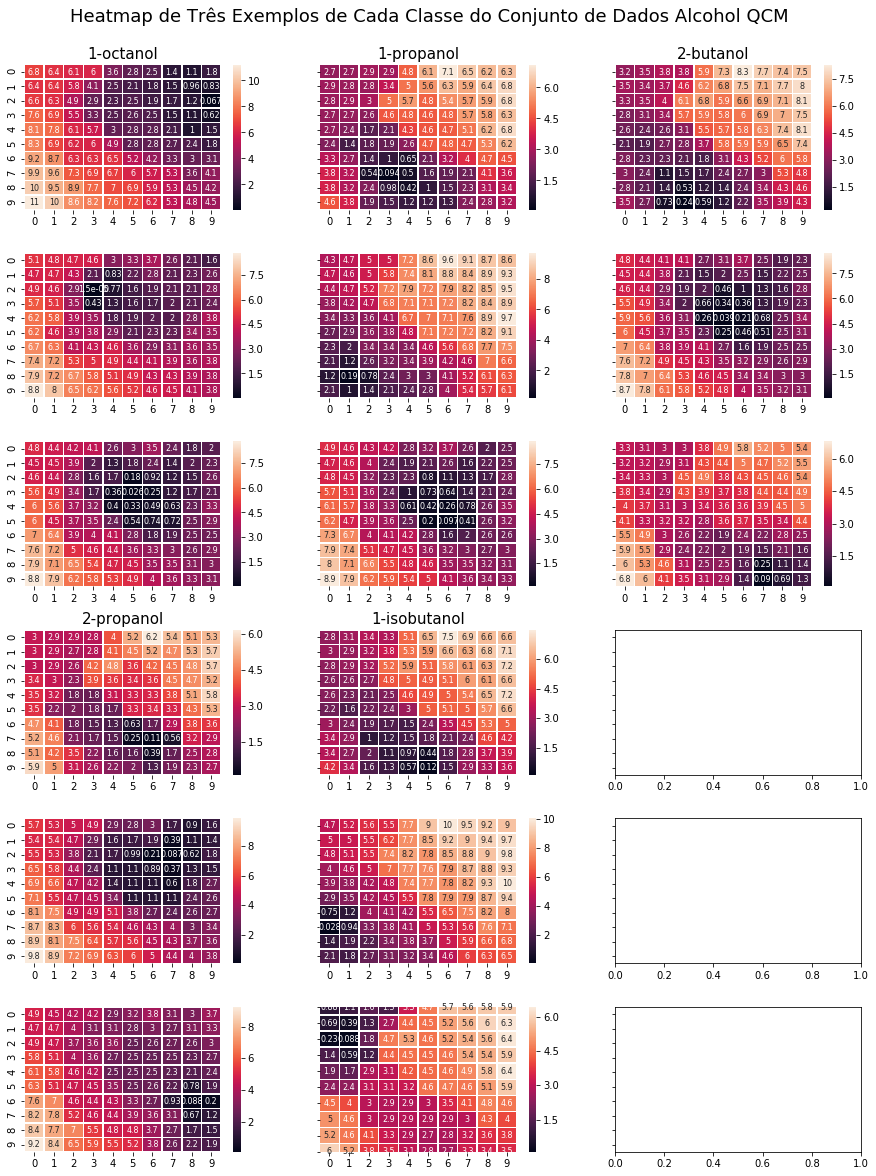

In [34]:
plt.rcParams['figure.figsize'] = [15, 20]
f, ax = plt.subplots(6, 3, sharey=True)
f.suptitle('Heatmap de Três Exemplos de Cada Classe do Conjunto de Dados Alcohol QCM', fontsize=18, x=0.5, y=0.92)

p1 = sns.heatmap(s.heatmap(QCM_X[0 ]), linewidth=0.5, annot=True, ax = ax[0,0], annot_kws={"size": 8})
p2 = sns.heatmap(s.heatmap(QCM_X[28]), linewidth=0.5, annot=True, ax = ax[1,0], annot_kws={"size": 8})
p3 = sns.heatmap(s.heatmap(QCM_X[73]), linewidth=0.5, annot=True, ax = ax[2,0], annot_kws={"size": 8})

p4 = sns.heatmap(s.heatmap(QCM_X[ 5]), linewidth=0.5, annot=True, ax = ax[0,1], annot_kws={"size": 8})
p5 = sns.heatmap(s.heatmap(QCM_X[30]), linewidth=0.5, annot=True, ax = ax[1,1], annot_kws={"size": 8})
p6 = sns.heatmap(s.heatmap(QCM_X[55]), linewidth=0.5, annot=True, ax = ax[2,1], annot_kws={"size": 8})

p8  = sns.heatmap(s.heatmap(QCM_X[10]), linewidth=0.5, annot=True, ax = ax[0,2], annot_kws={"size": 8})
p9  = sns.heatmap(s.heatmap(QCM_X[62]), linewidth=0.5, annot=True, ax = ax[1,2], annot_kws={"size": 8})
p10 = sns.heatmap(s.heatmap(QCM_X[87]), linewidth=0.5, annot=True, ax = ax[2,2], annot_kws={"size": 8})

p11 = sns.heatmap(s.heatmap(QCM_X[17]), linewidth=0.5, annot=True, ax = ax[3,0], annot_kws={"size": 8})
p12 = sns.heatmap(s.heatmap(QCM_X[65]), linewidth=0.5, annot=True, ax = ax[4,0], annot_kws={"size": 8})
p13 = sns.heatmap(s.heatmap(QCM_X[92]), linewidth=0.5, annot=True, ax = ax[5,0], annot_kws={"size": 8})

p14 = sns.heatmap(s.heatmap(QCM_X[24]), linewidth=0.5, annot=True, ax = ax[3,1], annot_kws={"size": 8})
p15 = sns.heatmap(s.heatmap(QCM_X[48]), linewidth=0.5, annot=True, ax = ax[4,1], annot_kws={"size": 8})
p16 = sns.heatmap(s.heatmap(QCM_X[121]), linewidth=0.5, annot=True, ax = ax[5,1], annot_kws={"size": 8})

p1.set_title( '1-octanol', fontsize=15)
p4.set_title( '1-propanol',fontsize=15)
p8.set_title( '2-butanol', fontsize=15)
p11.set_title('2-propanol', fontsize=15)
p14.set_title('1-isobutanol', fontsize=15)

f.subplots_adjust(hspace=0.3)

O Hit Map a seguir mostra que em sua grande maioria, exemplos de classes diferentes estão sendo mapeados para neurônios diferentes. No entato, para maioria das classes, esses neurônios que representam uma mesma classe estão distantes um do outro no mapa e muitas vezes, estão próximos a neurônios que representam outras classes. 

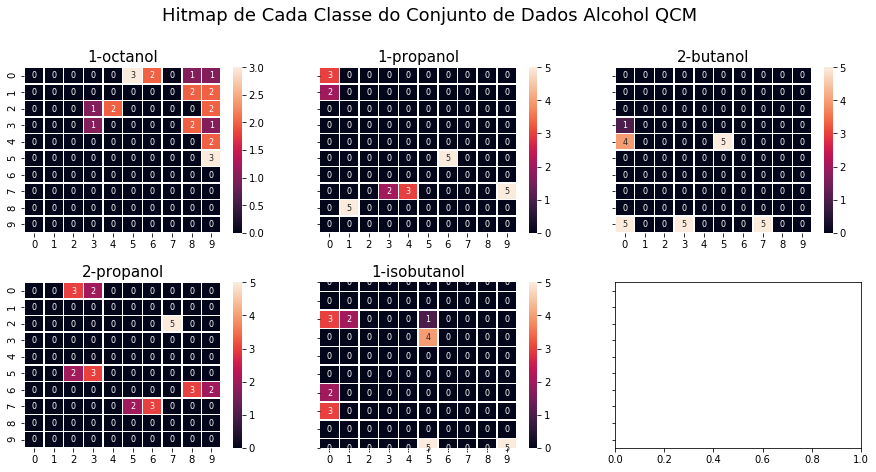

In [35]:
plt.rcParams['figure.figsize'] = [15, 7]
f, ax = plt.subplots(2, 3, sharey=True)

f.suptitle('Hitmap de Cada Classe do Conjunto de Dados Alcohol QCM', fontsize=18, x=0.5, y=1.0)

p1 = sns.heatmap(s.hitmap(QCM_X[QCM_Y==0]), linewidth=0.5, annot=True, ax = ax[0,0], annot_kws={"size": 8})
p2 = sns.heatmap(s.hitmap(QCM_X[QCM_Y==1]), linewidth=0.5, annot=True, ax = ax[0,1], annot_kws={"size": 8})
p3 = sns.heatmap(s.hitmap(QCM_X[QCM_Y==2]), linewidth=0.5, annot=True, ax = ax[0,2], annot_kws={"size": 8})
p4 = sns.heatmap(s.hitmap(QCM_X[QCM_Y==3]), linewidth=0.5, annot=True, ax = ax[1,0], annot_kws={"size": 8})
p5 = sns.heatmap(s.hitmap(QCM_X[QCM_Y==4]), linewidth=0.5, annot=True, ax = ax[1,1], annot_kws={"size": 8})

p1.set_title( '1-octanol', fontsize=15)
p2.set_title( '1-propanol',fontsize=15)
p3.set_title( '2-butanol', fontsize=15)
p4.set_title('2-propanol', fontsize=15)
p5.set_title('1-isobutanol', fontsize=15)

f.subplots_adjust(hspace=0.3)

A U-Matriz gerado mostra que os neurônios do centro do mapa estão mais distantes um dos outros, enquanto os neurônios dos cantos estão mais próximos.

De forma geral, foram obtidos bons resultados para o Alcohol QCM Sensor Dataset Data Set, onde o erro quantitativo e o topográfico foram baixos, sendo possível observar que as diferentes classes foram mapeados para neurônios diferentes do mapa. A proximidade entre as classes diferentes no grid do mapa pode ser explicada pela similariedade entre os tipos de álcool e o fato de serem coletados dados das amostras de cada tipo sobre condições diferentes, dessa forma é possível que álcoois de classes diferentes estejam próximos no mapa por terem sido coletados nas mesmas condições.  

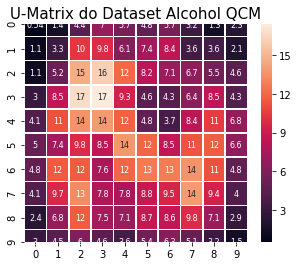

In [36]:
plt.rcParams['figure.figsize'] = [5, 4]
ax = sns.heatmap(s.u_matrix( ), linewidth=0.5, annot=True, annot_kws={"size": 8})
ax.set_title('U-Matrix do Dataset Alcohol QCM', fontsize=15)
plt.show()